In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

from rdkit import Chem
from rdkit.Chem import Descriptors, PandasTools, rdFingerprintGenerator, Draw, DataStructs
from rdkit.Chem.Scaffolds import MurckoScaffold

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

from scipy.linalg import lu

In [2]:
df = pd.read_csv('egfr_pca.csv')
df.head(5)

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,Molecule ChEMBL ID,Standardized Smiles,pIC50
0,-2.157104,-3.887835,-5.379733,0.620478,0.216540,0.829080,1.967688,-0.467686,-0.644161,0.519558,...,0.019272,-0.523474,0.143631,0.020328,-0.440783,0.692584,0.500490,CHEMBL271410,Cc1cccc(Nc2ncnc3ccncc23)c1NCCCN1CCOCC1,8.03
1,-3.455772,-3.889699,-2.118796,-1.830752,-0.974192,1.156326,2.927080,1.923785,-0.733871,2.112645,...,-0.219507,0.024209,0.246022,-0.251121,-0.250930,0.461087,0.264851,CHEMBL411243,CN(C)CCCCCNc1c(Br)cccc1Nc1ncnc2ccncc12,8.07
2,-5.714861,-3.429335,-2.929758,-2.342389,-1.070550,1.608673,3.432421,0.648863,-0.015651,1.051657,...,-0.161098,-0.022838,0.216702,-0.076283,-0.857441,0.274634,0.409436,CHEMBL270713,CN(C)CCNc1c(Br)cccc1Nc1ncnc2ccncc12,7.34
3,-11.269361,-2.923837,-0.794652,-2.154996,-1.832086,1.254151,0.802833,-0.190052,0.227171,0.334440,...,0.225433,-0.093439,0.393803,-0.140782,-0.515210,0.062264,0.399783,CHEMBL54475,Brc1cccc(Nc2ncnc3ncccc23)c1,6.16
4,-10.359805,-2.503253,-2.937203,-0.420325,1.334042,3.062380,0.491285,-0.071090,-0.179376,-0.825132,...,-0.698315,-1.050972,-0.127909,0.133436,0.035265,0.624337,0.655490,CHEMBL405772,Cc1cccc(Nc2ncnc3ccncc23)c1N,7.39


In [3]:
X = df.iloc[:,:48].values

# Kmeans clustering
Use first 48 pricipal components(85% cumulative explained variance) to cluster data.

In [4]:
X_max = np.amax(X,axis = 0)
X_min = np.amin(X,axis = 0)
scl_X = X/(X_max - X_min)

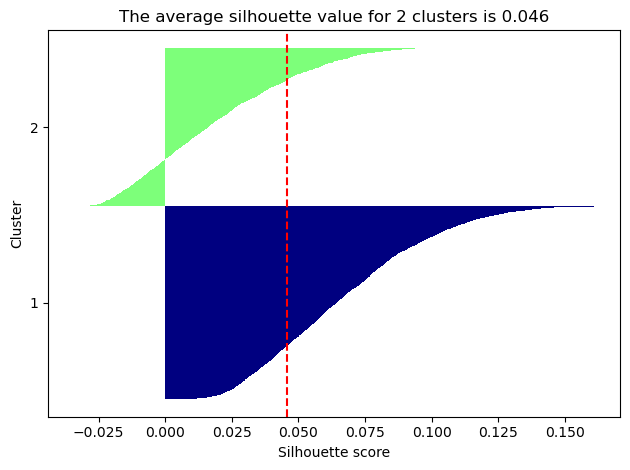

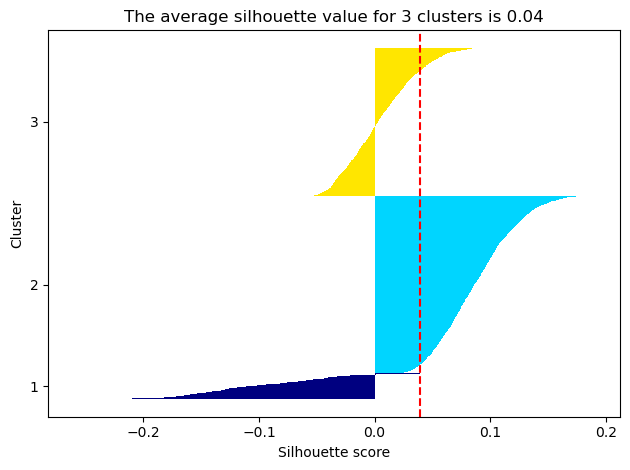

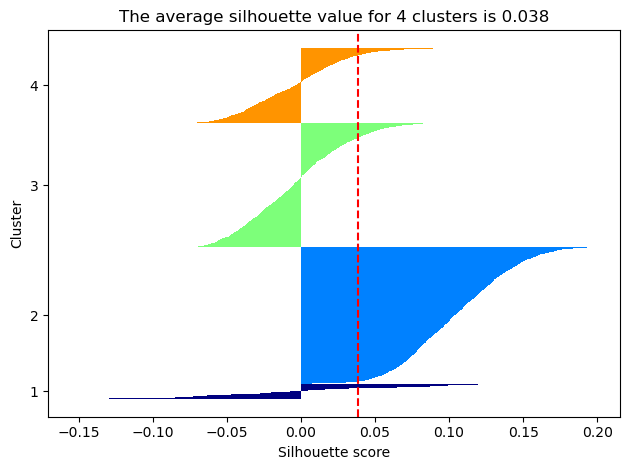

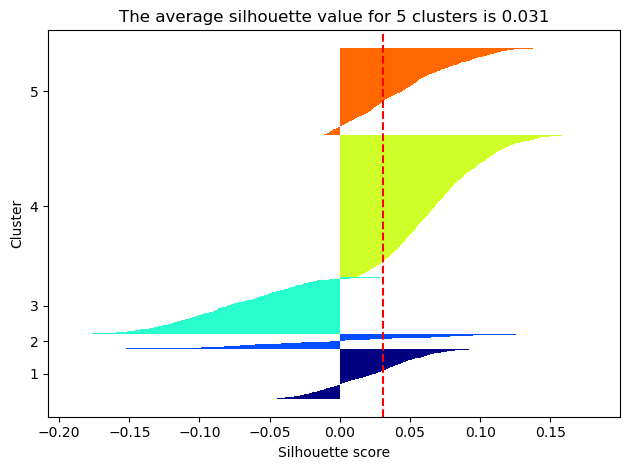

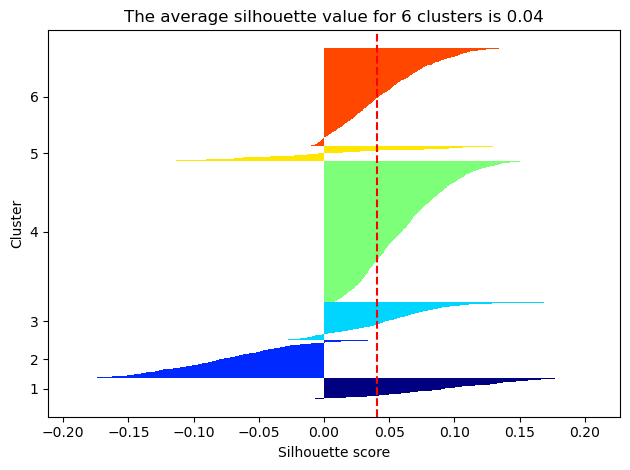

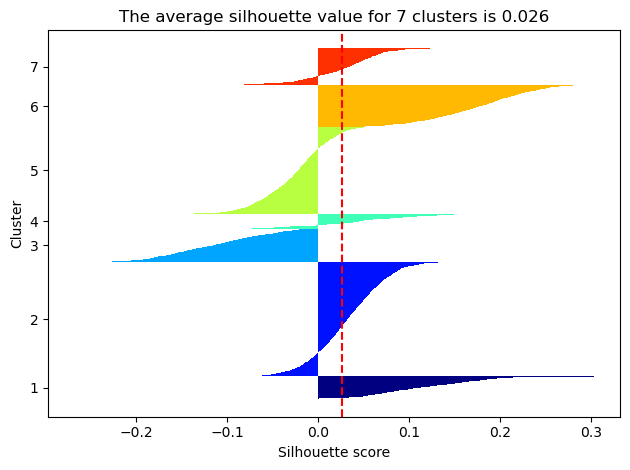

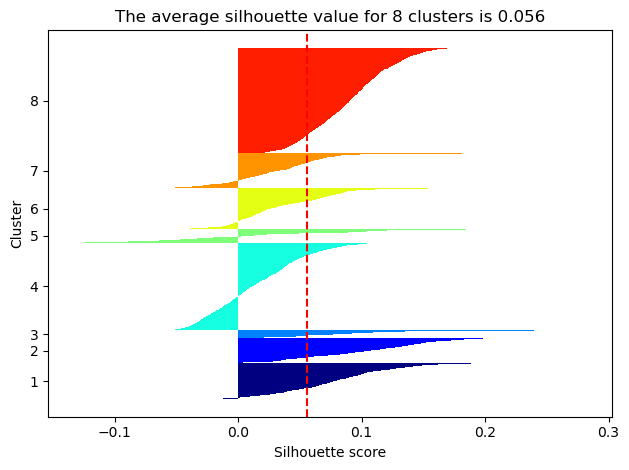

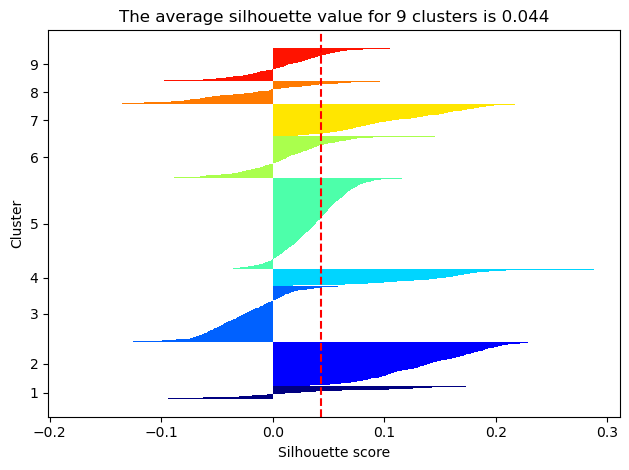

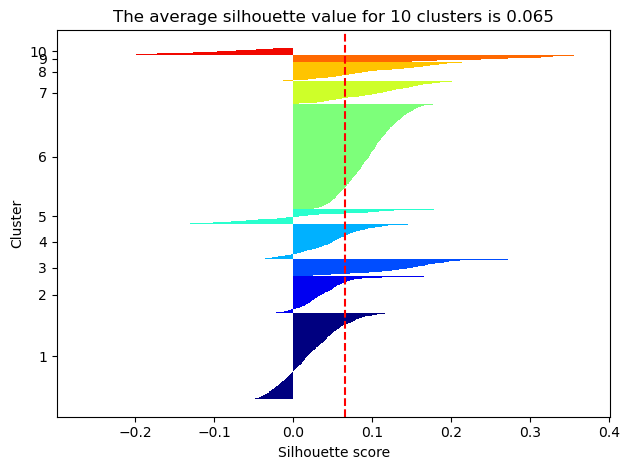

In [5]:
k_choice = list(range(2,11))
km_collection = {} #save y_km

for k in k_choice:
    km = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, max_iter = 300, tol = 1e-04, random_state = 0)
    y_km = km.fit_predict(scl_X)
    km_collection[f'{k} clusters'] = y_km
    cluster_labels = np.unique(y_km)
    clust_nums = cluster_labels.shape[0]
    sil_vals = silhouette_samples(scl_X, y_km, metric = 'euclidean')
    y_bottom, y_upper = 0,0
    yticks = []
    
    for i,j in enumerate(cluster_labels):
        j_sil_vals = sil_vals[y_km == j]
        j_sil_vals.sort()
        y_upper += len(j_sil_vals)
        color = cm.jet(float(i)/clust_nums)
        plt.barh(range(y_bottom, y_upper), j_sil_vals, height = 1, edgecolor = 'none', color = color)
        yticks.append((y_bottom + y_upper)/2)
        y_bottom += len(j_sil_vals)
    
    sil_avg = np.mean(sil_vals)
    plt.axvline(sil_avg, color = 'red', linestyle = '--')
    plt.yticks(yticks, cluster_labels + 1)
    plt.title(f'The average silhouette value for {k} clusters is {round(sil_avg,3)}')
    plt.ylabel('Cluster')
    plt.xlabel("Silhouette score")
    plt.tight_layout()
    plt.show()
    

Clustering results are bad. Least worst is k=10.

In [6]:
df['Cluster label'] = km_collection['10 clusters']

In [7]:
PandasTools.AddMoleculeColumnToFrame(df,'Standardized Smiles', 'Molecule', includeFingerprints = False)

In [8]:
for i in df.index:
    mol = df.loc[i,'Molecule']
    try:
        scaff = MurckoScaffold.MakeScaffoldGeneric(MurckoScaffold.GetScaffoldForMol(mol))
    except:
        scaff = None
    df.loc[i,'Scaffold'] = scaff   

In [9]:
def get_sim_array(fps):
    sim_array = []
    for i in range(len(fps)):
        sims = i*[0] + DataStructs.BulkTanimotoSimilarity(fps[i],fps[i:])
        sim_array.append(sims)

    #Matrix math
    self_sim = np.diag(np.array([1]*len(fps)))    
    sim_array = np.array(sim_array)
    sim_array[sim_array != 1] = 0 
    sim_array = sim_array + sim_array.T - self_sim
    return sim_array

In [10]:
def common_scaffold(red_matrix, ind_list):
    shared_scaff = {}
    for i in range(red_matrix.shape[0]):
        if np.sum(red_matrix[i,:]) > 0:
            common_ind = np.where(red_matrix[i,:] == 1, ind_list, -1)
            common_ind = common_ind[common_ind >= 0]
            shared_scaff[i] = list(common_ind)
            
    return shared_scaff    

In [11]:
fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize = 2048)
fps = [fpgen.GetFingerprint(x) for x in df['Scaffold']]

cluster_groups = {}

for label,group in df.groupby('Cluster label'):
    ind = list(group.index)
    fps = [fpgen.GetFingerprint(x) for x in df.loc[ind,'Scaffold']]
    sim_array = get_sim_array(fps)
    p,l,u = lu(sim_array)
    red_matrix = p@u
    repeats = common_scaffold(red_matrix, ind)
    cluster_groups[f'cluster_{label}'] = repeats
    
    
    

In [12]:
for label in cluster_groups:
    scaffs = []
    counts = []
    for scaffold in cluster_groups[label]:
        ind = cluster_groups[label][scaffold][0]
        scaff_count = len(cluster_groups[label][scaffold])
        scaffs.append(df.loc[ind,'Scaffold'])
        counts.append(str(scaff_count))
        
    print(f'{label}, {len(counts)}')
    img = Draw.MolsToGridImage(scaffs, legends = counts, maxMols = 70, subImgSize = (500,500), returnPNG = False)
    img.save(f'{label}.png')
    

cluster_0, 48
cluster_1, 22
cluster_2, 28
cluster_3, 37
cluster_4, 17
cluster_5, 46
cluster_6, 21
cluster_7, 33
cluster_8, 12
cluster_9, 9


See if using fewer principal components improves results.

In [13]:
x = df.iloc[:,:2].values 
x_max = np.amax(x,axis = 0)
x_min = np.amin(x,axis = 0)
scl_x = x/(x_max - x_min)

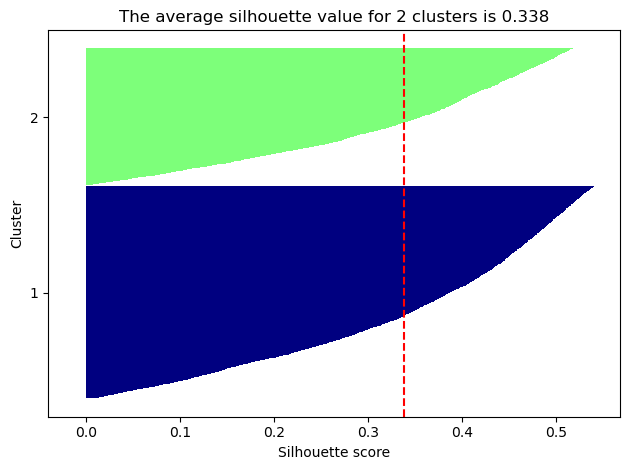

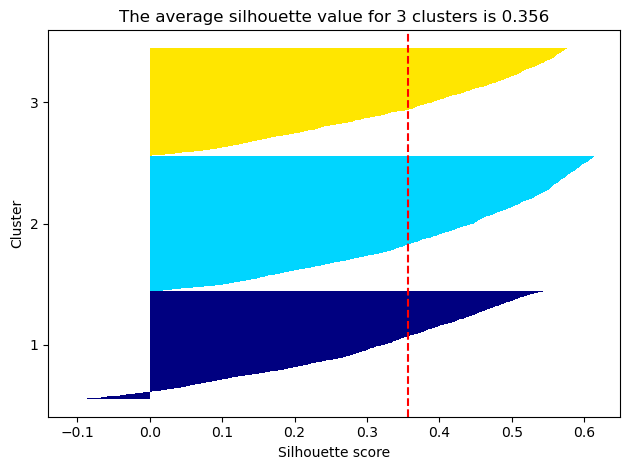

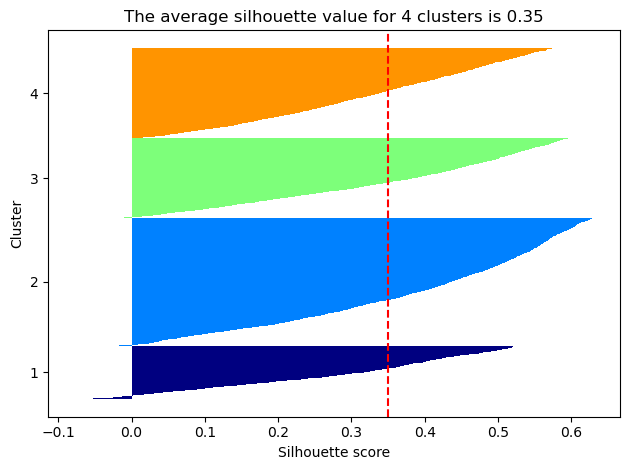

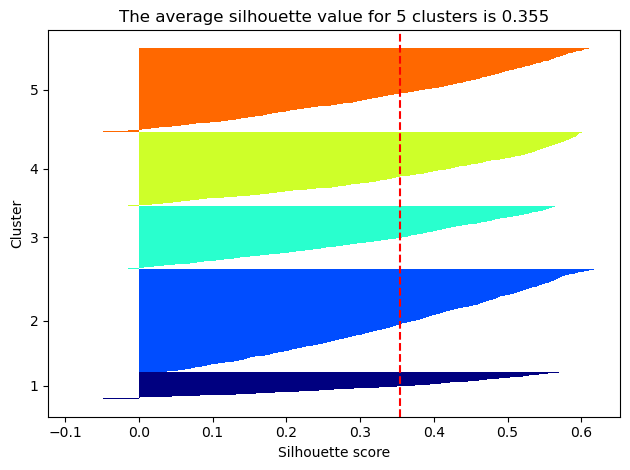

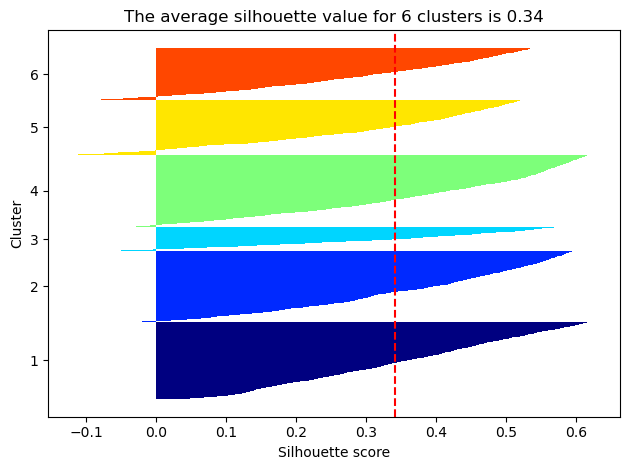

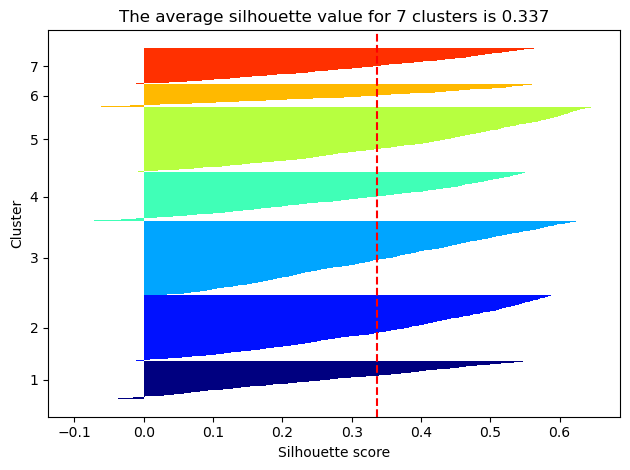

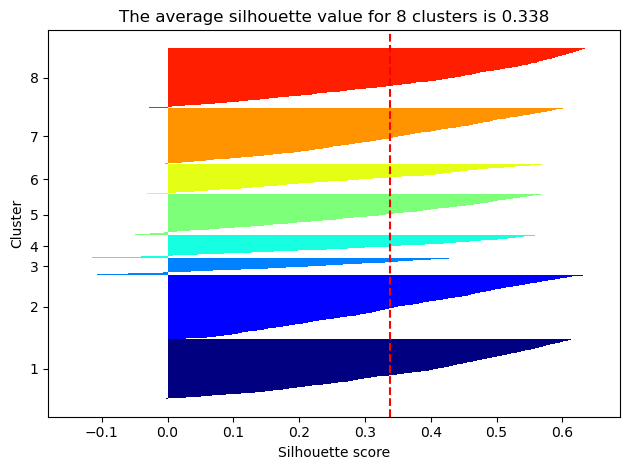

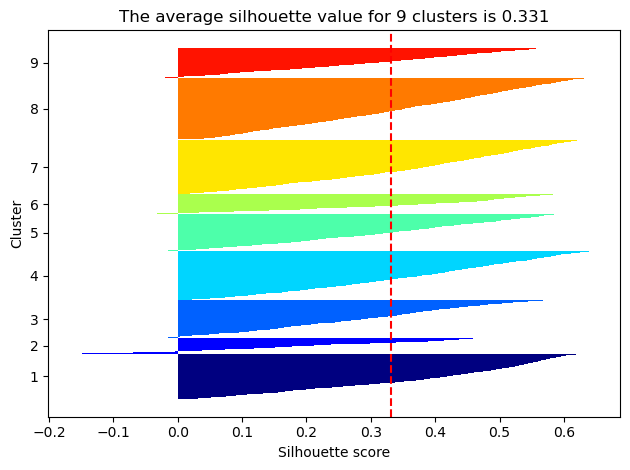

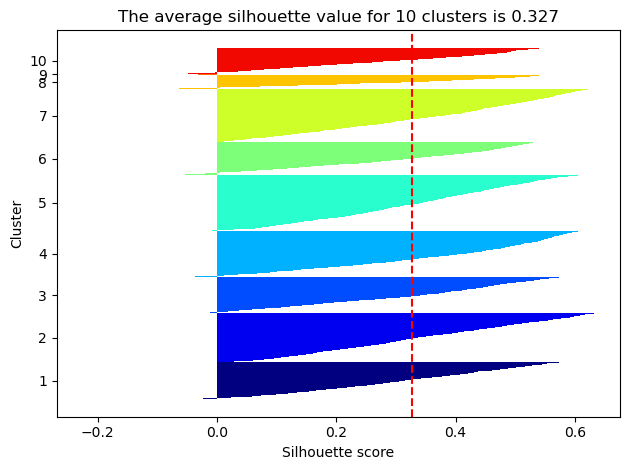

In [14]:
k_choice_2 = list(range(2,11))
km_collection_2 = {} #save y_km

for k in k_choice_2:
    km = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, max_iter = 300, tol = 1e-04, random_state = 0)
    y_km = km.fit_predict(scl_x)
    km_collection_2[f'{k}_clusters'] = y_km
    cluster_labels = np.unique(y_km)
    clust_nums = cluster_labels.shape[0]
    sil_vals = silhouette_samples(scl_x, y_km, metric = 'euclidean')
    y_bottom, y_upper = 0,0
    yticks = []
    
    for i,j in enumerate(cluster_labels):
        j_sil_vals = sil_vals[y_km == j]
        j_sil_vals.sort()
        y_upper += len(j_sil_vals)
        color = cm.jet(float(i)/clust_nums)
        plt.barh(range(y_bottom, y_upper), j_sil_vals, height = 1, edgecolor = 'none', color = color)
        yticks.append((y_bottom + y_upper)/2)
        y_bottom += len(j_sil_vals)
    
    sil_avg = np.mean(sil_vals)
    plt.axvline(sil_avg, color = 'red', linestyle = '--')
    plt.yticks(yticks, cluster_labels + 1)
    plt.title(f'The average silhouette value for {k} clusters is {round(sil_avg,3)}')
    plt.ylabel('Cluster')
    plt.xlabel("Silhouette score")
    plt.tight_layout()
    plt.show()

Results are still suboptimal, but better than first kmeans clustering attempt.

<function matplotlib.pyplot.show(close=None, block=None)>

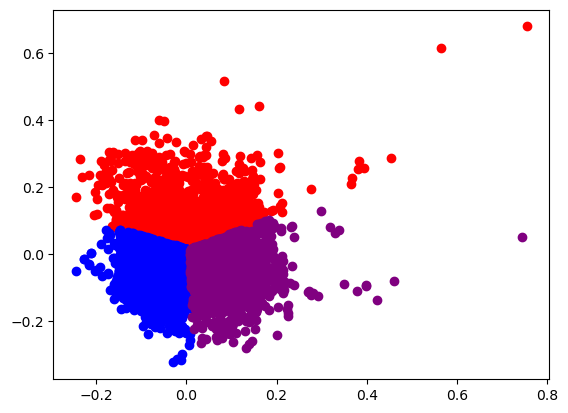

In [16]:
color = ['red','blue', 'purple']
for c in range(3):
    choice = km_collection_2['3_clusters']
    plt.scatter(scl_x[choice == c,0], scl_x[choice == c, 1], color = color[c] )
plt.show

Dataset is not linearly separable. Move on to a different dataset.